In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# building the dataset
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #kaining init
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # to make initial logits close to zero
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [11]:
hpreact.shape

torch.Size([32, 200])

In [12]:
hpreact.mean(0,keepdim=True).shape

torch.Size([1, 200])

In [13]:
hpreact.std(0,keepdim=True)

tensor([[1.3558, 1.0380, 1.1400, 0.7320, 1.1605, 1.4651, 1.9289, 1.5232, 1.4252,
         1.2851, 1.3524, 1.3369, 1.4715, 1.2483, 1.3107, 1.6235, 1.0967, 1.4431,
         1.1748, 1.5887, 1.3626, 1.0880, 1.2424, 1.0703, 1.3868, 0.7471, 1.2735,
         1.5220, 1.1894, 1.1599, 1.0580, 1.1935, 0.9980, 1.1445, 1.1674, 1.0424,
         1.4455, 1.2111, 0.8829, 0.9107, 1.0582, 1.2010, 1.4223, 1.0079, 1.1919,
         1.5200, 1.3413, 1.4154, 1.4260, 1.6018, 1.2796, 1.2320, 1.2853, 1.0116,
         1.5774, 1.3184, 1.0811, 1.3938, 1.2372, 0.9800, 1.3435, 1.4111, 1.1743,
         1.2943, 1.3199, 1.2122, 1.2723, 1.7611, 1.0524, 1.2356, 1.2222, 1.1966,
         1.3707, 1.3427, 1.1280, 1.1597, 1.3492, 1.4842, 0.9296, 1.2549, 1.2170,
         0.9955, 0.9919, 1.0357, 1.0273, 1.4719, 1.2842, 1.2582, 3.0079, 1.5895,
         1.5322, 1.3161, 1.2326, 0.9735, 0.9273, 1.4207, 1.0574, 1.0702, 1.1402,
         1.2404, 1.3857, 1.1218, 0.9742, 1.1455, 1.1647, 1.5384, 1.2634, 1.4989,
         0.8944, 1.0888, 1.7

In [9]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation //we need to make this roughly gaussian
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani #receive update in the direction
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [10]:
logits[0]

tensor([-2.9433,  1.7033, -0.1491, -0.6337, -0.2506,  1.9912, -1.0583, -1.1586,
        -0.0168,  2.3001, -2.0891, -1.5072,  2.9150,  1.6254,  2.9859,  0.7832,
        -0.6382, -3.9366,  1.3895,  1.1865,  0.8465, -1.4758,  0.3449, -2.4001,
        -2.2058,  2.5447, -0.3120], grad_fn=<SelectBackward0>)

In [14]:
for i in range(1):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
  print(ix.shape)
  print(Xtr.shape)
  Xb, Yb = Xtr[ix], Ytr[ix]
  print(Xb.shape)
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  print(embcat.shape)

torch.Size([32])
torch.Size([182625, 3])
torch.Size([32, 3])
torch.Size([32, 30])


In [9]:
### fixing the initialization issue

In [10]:
logits  = torch.tensor([0.0,0.0,0.0,0.0])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

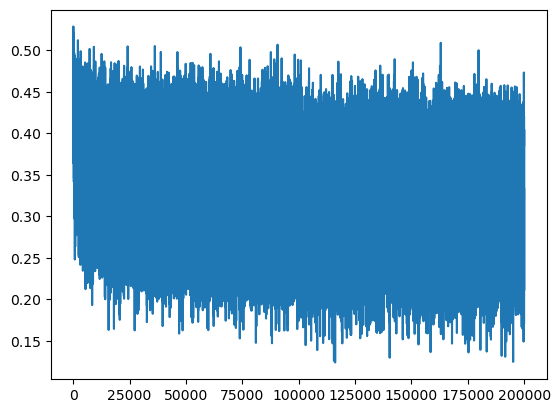

In [11]:
plt.plot(lossi)

In [34]:
# calibrate the batch norm at the end of training
# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0],-1)
#     hpreact = embcat @ W1 + b1
#     # measure the mean/std over the entire training set
#     bnmean = hpreact.mean(0,keepdim=True)
#     bnstd = hpreact.std(0,keepdim=True)

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


# fixing the tanh

(array([  1.,   0.,   0.,   0.,   2.,   1.,   1.,   2.,   4.,  11.,  14.,
         18.,  13.,  19.,  42.,  54.,  66.,  84., 103., 123., 170., 216.,
        262., 273., 347., 423., 524., 599., 537., 456., 416., 323., 247.,
        240., 185., 148., 129.,  81.,  82.,  57.,  39.,  29.,  19.,  16.,
         11.,   5.,   3.,   2.,   1.,   2.]),
 array([-6.35469627, -6.12598268, -5.89726908, -5.66855548, -5.43984188,
        -5.21112828, -4.98241468, -4.75370109, -4.52498749, -4.29627389,
        -4.06756029, -3.83884669, -3.61013309, -3.3814195 , -3.1527059 ,
        -2.9239923 , -2.6952787 , -2.4665651 , -2.23785151, -2.00913791,
        -1.78042431, -1.55171071, -1.32299711, -1.09428351, -0.86556992,
        -0.63685632, -0.40814272, -0.17942912,  0.04928448,  0.27799808,
         0.50671167,  0.73542527,  0.96413887,  1.19285247,  1.42156607,
         1.65027966,  1.87899326,  2.10770686,  2.33642046,  2.56513406,
         2.79384766,  3.02256125,  3.25127485,  3.47998845,  3.70870205,
 

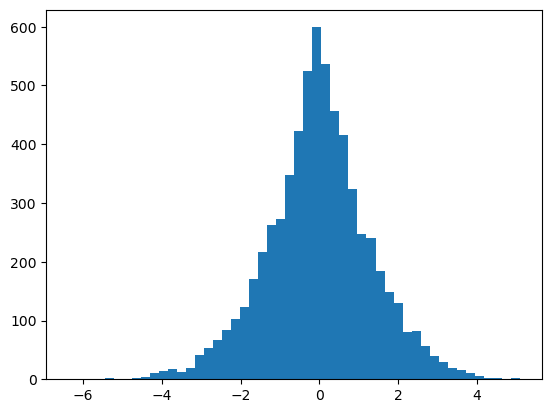

In [15]:
plt.hist(hpreact.view(-1).tolist(),50)

(array([463., 241., 185., 165., 147., 111.,  97., 124.,  93., 102., 107.,
         76., 107.,  95., 108., 113.,  89.,  96., 112.,  93., 118.,  85.,
         67., 132., 111., 112., 106., 107.,  85.,  92., 103.,  80.,  93.,
         91.,  81.,  93., 120.,  82., 118., 110., 103., 103., 110., 114.,
        114., 135., 166., 171., 242., 432.]),
 array([-9.99993980e-01, -9.59995645e-01, -9.19997311e-01, -8.79998976e-01,
        -8.40000641e-01, -8.00002307e-01, -7.60003972e-01, -7.20005637e-01,
        -6.80007303e-01, -6.40008968e-01, -6.00010633e-01, -5.60012299e-01,
        -5.20013964e-01, -4.80015630e-01, -4.40017295e-01, -4.00018960e-01,
        -3.60020626e-01, -3.20022291e-01, -2.80023956e-01, -2.40025622e-01,
        -2.00027287e-01, -1.60028952e-01, -1.20030618e-01, -8.00322831e-02,
        -4.00339484e-02, -3.56137753e-05,  3.99627209e-02,  7.99610555e-02,
         1.19959390e-01,  1.59957725e-01,  1.99956059e-01,  2.39954394e-01,
         2.79952729e-01,  3.19951063e-01,  3.59949

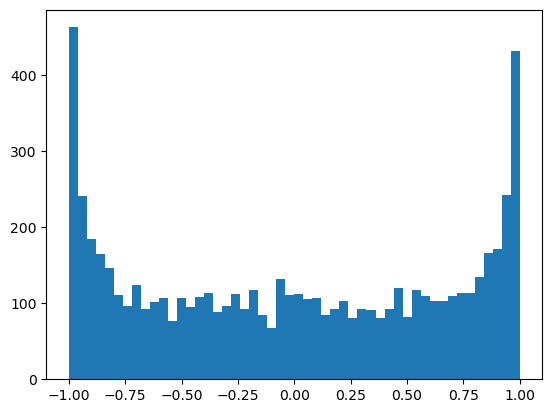

In [16]:
plt.hist(h.view(-1).tolist(),50)

In [17]:
### Calculating the init scale

In [22]:
(torch.randn(1000) * 0.1).std()

tensor(0.1007)

In [24]:
5/3 / (30**0.5) # tanh gain must be added

0.3042903097250923

tensor(0.0057) tensor(0.9982)
tensor(-0.0002) tensor(0.9822)


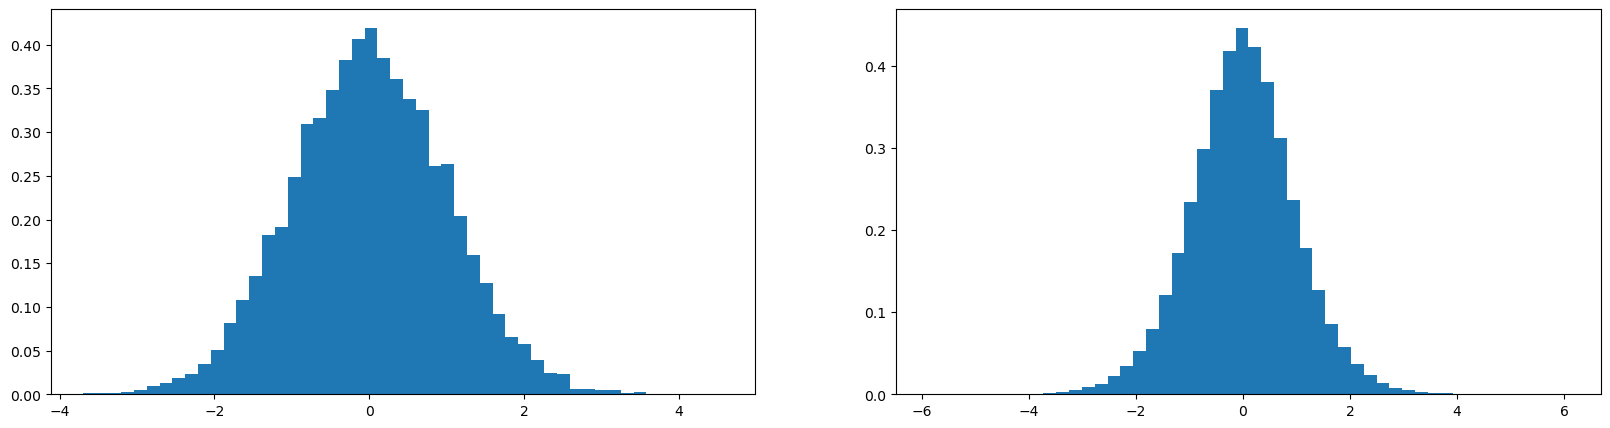

In [19]:
x = torch.randn(1000,10)
w = torch.randn(10,200)/ 10**0.5     # if we scale up,guassian gets bigger and bigger so does standard deviation.
y = x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);